<a href="https://colab.research.google.com/github/bugreator/ML_cybersecurity_lab3/blob/main/ml_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import keras.backend as K
from keras import Model

import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("/content/drive/MyDrive/lab3")

## load model and load data

In [2]:
cl_valid_path = './data/cl/valid.h5'
cl_test_path = './data/cl/test.h5'
bd_valid_path = './data/bd/bd_valid.h5'
bd_test_path = './data/bd/bd_test.h5'
bd_net_path = './models/bd_net.h5'


def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))

    return x_data, y_data



In [3]:
cl_x_valid, cl_y_valid = data_loader(cl_valid_path)
cl_x_test, cl_y_test = data_loader(cl_test_path)
bd_x_valid, bd_y_valid = data_loader(bd_valid_path)
bd_x_test, bd_y_test = data_loader(bd_test_path)
net = keras.models.load_model(bd_net_path)

In [4]:
# evaluate the net (from eval.py)
def eval(net,cl_x_test,cl_y_test,bd_x_test,bd_y_test):
  cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  print('Clean Classification accuracy:', clean_accuracy)
  bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100

  print('Attack Success Rate:', asr)
  return clean_accuracy,asr

In [5]:
print(net.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [6]:
!python eval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5

2021-12-17 02:47:07.302976: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0


## repair B-Net


The main idea is to get the output of layer before the last maxpooling layer which is layer conv_3. Prune the layer's channel based on the increasing order of the average outputover the entire validation dataset.

### New net: we want to get the netpart before layer pool_3

In [7]:
# The network finished 
# model_pool_3 = keras.Model(net.input,net.get_layer("pool_3").output)
# model_pool_3.summary()

model_conv_3 = keras.Model(net.input,net.get_layer("conv_3").output)
model_conv_3.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
Total params: 29,880
Trainable params: 29,880
Non-trainable p

In [8]:
# get the sort over cl_x_valid
predict_output = model_conv_3.predict(cl_x_valid)
# print(predict_output.shape)
predict_output_mean = predict_output.mean(axis=(0,1,2))
prune_sort = np.argsort(predict_output_mean)

In [9]:
print("prune order:", prune_sort)

prune order: [ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43  3 58 42  1 29 16  5 56
  8 11 46 54 10  4 18  7 28 35 52 57]


In [10]:
def acc(predict,target):
  accuracy = np.mean(np.equal(predict, target) )*100
  return accuracy

In [11]:
pruned_net = keras.models.load_model(bd_net_path)
net = keras.models.load_model(bd_net_path)
# net is the original net

original_acc = 98.64899974019225
cl_classification_accuracy_valid_list = []
cl_classification_accuracy_test_list = []
attack_success_rate = []

trigger = np.ones(4) # record after 2%, 4%, 10%
ratio_list = np.array([2,4,10,30])

for i in range(len(prune_sort)):
  pruned_layer = pruned_net.get_layer('conv_3')
  w,b = pruned_layer.get_weights()
  # prune the current channel
  w[:,:,:,prune_sort[i]]=0
  b[prune_sort[i]]=0
  pruned_layer.set_weights((w,b))
  # test the current accuracy

  cl_y_valid_predict = np.argmax(pruned_net.predict(cl_x_valid),axis=1)
  
  val_acc = acc(cl_y_valid_predict,cl_y_valid)
  cl_classification_accuracy_valid_list.append(val_acc)
  ratio = 1-val_acc/original_acc
  print("prune round",i+1,"accuracy on valid:",val_acc)

  for j in range(len(ratio_list)):
    if(ratio*100 > ratio_list[j] and trigger[j]==1):
      pruned_net.save('./models/prune_net_'+'ratio'+str(ratio_list[j])+'.h5')
      trigger[j]=0
  
    
  cl_net_pred = np.argmax(net.predict(cl_x_test), axis=1)
  cl_pruned_net_pred = np.argmax(pruned_net.predict(cl_x_test), axis=1)
  cl_pred = np.zeros(len(cl_net_pred))
  for j in range(len(cl_pruned_net_pred)):
    if(cl_net_pred[j]==cl_pruned_net_pred[j]):
      cl_pred[j]=cl_net_pred[j]
    else:
      cl_pred[j]=1283

  test_acc = np.mean(np.equal(cl_pred, cl_y_test))*100


  bd_net_pred = np.argmax(net.predict(bd_x_test), axis=1)
  bd_pruned_net_pred = np.argmax(pruned_net.predict(bd_x_test), axis=1)
  bd_pred = np.zeros(len(bd_net_pred))
  for j in range(len(bd_pruned_net_pred)):
    if(bd_net_pred[j]==bd_pruned_net_pred[j]):
      bd_pred[j]=bd_net_pred[j]
    else:
      bd_pred[j]=1283


  
  test_asr = np.mean(np.equal(bd_pred, bd_y_test))*100



  cl_classification_accuracy_test_list.append(test_acc)
  attack_success_rate.append(test_asr)
  print("clean test classification accuracy is:", test_acc,"attack success rate is",test_asr)


prune round 1 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 2 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 3 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 4 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 5 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 6 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 7 accuracy on valid: 98.64899974019225
clean test classification accuracy is: 98.62042088854248 attack success rate is 100.0
prune round 8 accuracy on valid: 98.64899

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


clean test classification accuracy is: 95.74434918160561 attack success rate is 100.0
prune round 46 accuracy on valid: 95.20221702606739
clean test classification accuracy is: 95.34684333593141 attack success rate is 99.97661730319564
prune round 47 accuracy on valid: 94.77786438035854
clean test classification accuracy is: 95.03507404520654 attack success rate is 99.97661730319564
prune round 48 accuracy on valid: 94.344851476574
clean test classification accuracy is: 94.57521434138737 attack success rate is 99.98441153546376
prune round 49 accuracy on valid: 93.85121676625964
clean test classification accuracy is: 94.00623538581449 attack success rate is 99.97661730319564
prune round 50 accuracy on valid: 92.16246644149996
clean test classification accuracy is: 92.33047544816836 attack success rate is 80.576773187841
prune round 51 accuracy on valid: 89.17467740538669
clean test classification accuracy is: 89.68043647700702 attack success rate is 80.6469212782541
prune round 52 accu

## 1. evaluate the three repaired net with X={2%,4%,10%}

We can see from the results after we fit the original eval.py code to the Good Net which is asked in the lab requirment. The final results are shown above. When the accuracy drops to X% we want, the code record the corresponding net parameters.

show the result on valid and test dataset

In [12]:
bd_net = keras.models.load_model(bd_net_path)
for i in range(len(ratio_list)):
  path = "./models/prune_net_ratio"+str(ratio_list[i])+".h5"
  pruned_bd_net = keras.models.load_model(path)
  cl_net_pred = np.argmax(bd_net.predict(cl_x_test), axis=1)
  cl_pruned_net_pred = np.argmax(pruned_bd_net.predict(cl_x_test), axis=1)
  cl_pred = np.zeros(len(cl_net_pred))
  for j in range(len(cl_pruned_net_pred)):
    if(cl_net_pred[j]==cl_pruned_net_pred[j]):
      cl_pred[j]=cl_net_pred[j]
    else:
      cl_pred[j]=1283

  test_acc = np.mean(np.equal(cl_pred, cl_y_test))*100


  bd_net_pred = np.argmax(bd_net.predict(bd_x_test), axis=1)
  bd_pruned_net_pred = np.argmax(pruned_bd_net.predict(bd_x_test), axis=1)
  bd_pred = np.zeros(len(bd_net_pred))
  for j in range(len(bd_pruned_net_pred)):
    if(bd_net_pred[j]==bd_pruned_net_pred[j]):
      bd_pred[j]=bd_net_pred[j]
    else:
      bd_pred[j]=1283


  
  test_asr = np.mean(np.equal(bd_pred, bd_y_test))*100
  print("When X =",ratio_list[i],"%","clean test classification accuracy is:", test_acc,"attack success rate is",test_asr)



When X = 2 % clean test classification accuracy is: 95.74434918160561 attack success rate is 100.0
When X = 4 % clean test classification accuracy is: 94.57521434138737 attack success rate is 99.98441153546376
When X = 10 % clean test classification accuracy is: 84.3335931410756 attack success rate is 77.20966484801247
When X = 30 % clean test classification accuracy is: 44.551831644583004 attack success rate is 16.03273577552611


## 2. plots of the result with script eval.py

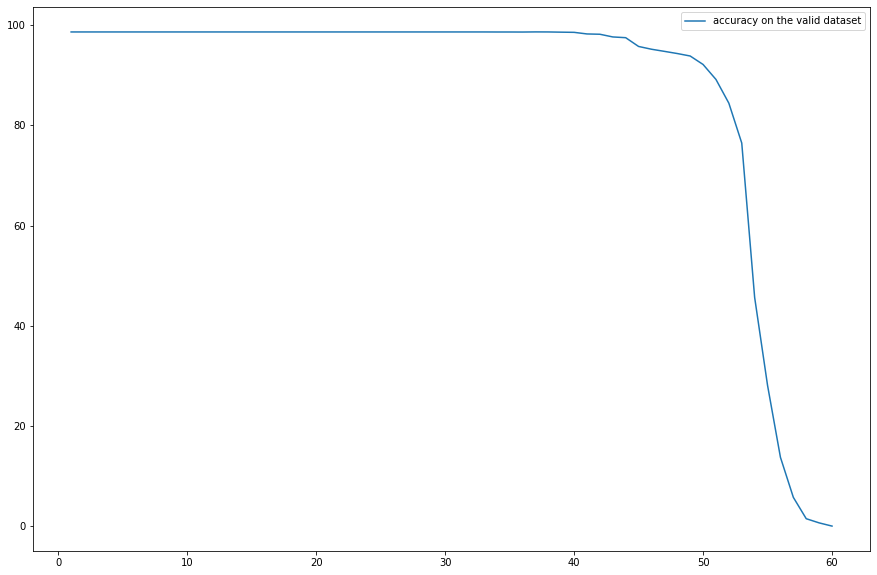

In [13]:
plt.figure(figsize=(15,10))
plt.plot([i for i in range(1,61)],cl_classification_accuracy_valid_list,label="accuracy on the valid dataset")
plt.legend()
# cl_classification_accuracy_valid_list = []
# cl_classification_accuracy_test_list = []
# attack_success_rate = []

The plot below is the relationship between the accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned.

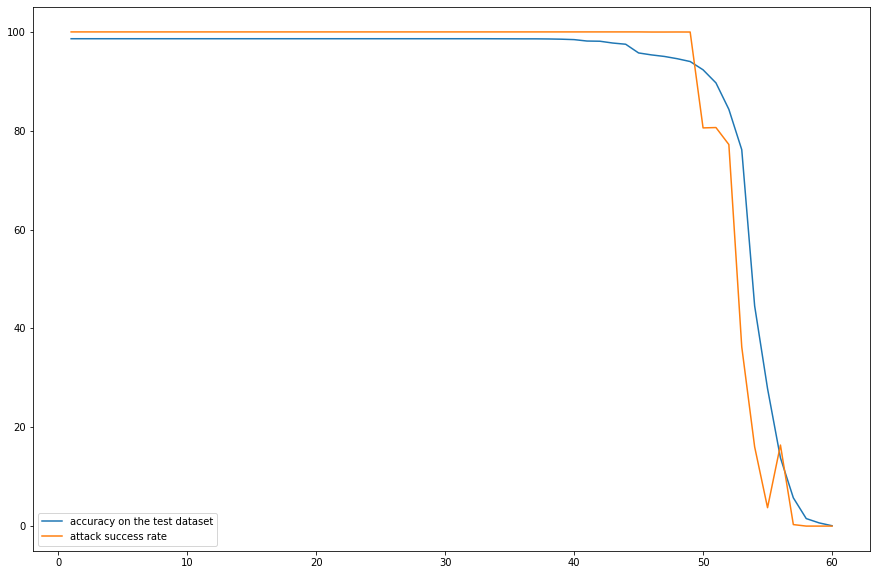

In [14]:
plt.figure(figsize=(15,10))
plt.plot([i for i in range(1,61)],cl_classification_accuracy_test_list,label="accuracy on the test dataset")
plt.plot([i for i in range(1,61)],attack_success_rate, label="attack success rate")
plt.legend()